# GA vs PSO vs RS

In [ ]:
!pip install numpy scikit-learn

In [ ]:
!pip install numpy scikit-learn matplotlib

## Codes

best_score_ga0.9800000000000001
time_ga23.014392375946045
best_score_pso0.96
time_pso28.199132680892944


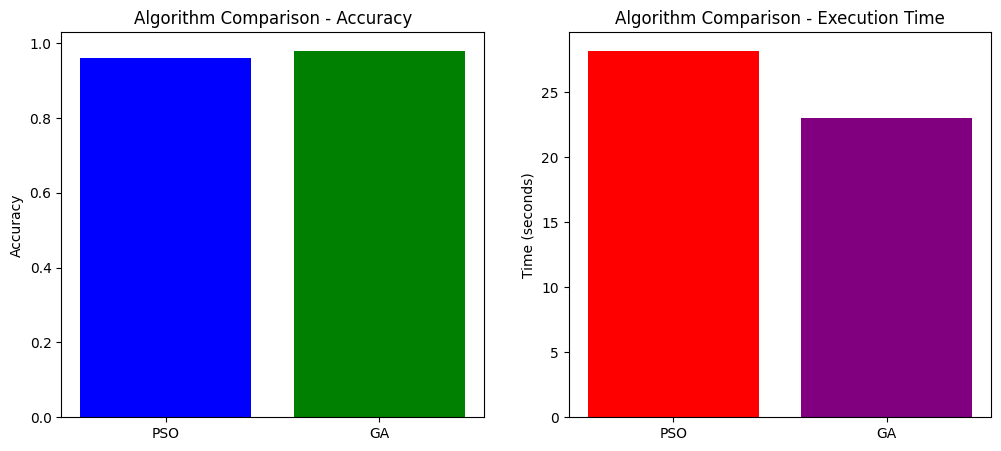

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# PSO sınıfı
class Particle:
    def __init__(self, bounds):
        self.position = np.random.uniform(low=bounds[0], high=bounds[1], size=len(bounds[0]))
        self.velocity = np.random.uniform(low=-1, high=1, size=len(bounds[0]))
        self.best_position = self.position.copy()
        self.best_score = -np.inf

class ParticleSwarmOptimizer:
    def __init__(self, num_particles, bounds, num_iterations):
        self.particles = [Particle(bounds) for _ in range(num_particles)]
        self.global_best_position = None
        self.global_best_score = -np.inf
        self.bounds = bounds
        self.num_iterations = num_iterations

    def optimize(self, objective_function):
        for _ in range(self.num_iterations):
            for particle in self.particles:
                score = objective_function(particle.position)
                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()

                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()

            for particle in self.particles:
                r1, r2 = np.random.rand(), np.random.rand()
                velocity_update = (0.5 * particle.velocity
                                   + r1 * (particle.best_position - particle.position)
                                   + r2 * (self.global_best_position - particle.position))
                particle.velocity = velocity_update
                particle.position += particle.velocity
                particle.position = np.clip(particle.position, self.bounds[0], self.bounds[1])

        return self.global_best_position, self.global_best_score

# Genetik Algoritma sınıfı
class GeneticAlgorithm:
    def __init__(self, population_size, bounds, num_iterations, crossover_prob, mutation_prob):
        self.population_size = population_size
        self.bounds = bounds
        self.num_iterations = num_iterations
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.population = np.random.uniform(low=bounds[0], high=bounds[1], size=(population_size, len(bounds[0])))

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_prob:
            crossover_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            return child1, child2
        else:
            return parent1, parent2

    def mutate(self, individual):
        for i in range(len(individual)):
            if np.random.rand() < self.mutation_prob:
                individual[i] = np.random.uniform(self.bounds[i][0], self.bounds[i][1])
        return individual

    def select_parents(self, fitness_scores):
        probs = fitness_scores / fitness_scores.sum()
        parents_indices = np.random.choice(range(self.population_size), size=2, p=probs, replace=False)
        return self.population[parents_indices[0]], self.population[parents_indices[1]]

    def optimize(self, objective_function):
        best_score = -np.inf
        best_individual = None

        for _ in range(self.num_iterations):
            fitness_scores = np.array([objective_function(individual) for individual in self.population])
            new_population = []

            for __ in range(self.population_size // 2):
                parent1, parent2 = self.select_parents(fitness_scores)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_population.extend([child1, child2])

            self.population = np.array(new_population)
            current_best_score = fitness_scores.max()
            if current_best_score > best_score:
                best_score = current_best_score
                best_individual = self.population[fitness_scores.argmax()]

        return best_individual, best_score

# Hedef fonksiyon: SVM modeli için cross-validation skoru
def objective_function(x):
    C, gamma = x
    model = SVC(C=C, gamma=gamma)
    scores = cross_val_score(model, X, y, cv=5)
    return np.mean(scores)

# Algoritmaları karşılaştıran fonksiyon
def compare_algorithms():
    # Iris veri setini yükleme
    iris = datasets.load_iris()
    global X, y
    X = iris.data
    y = iris.target

    # PSO parametreleri
    num_particles = 30
    bounds = [(0.1, 100), (0.0001, 1)]
    num_iterations = 50

    # PSO çalıştırma
    start_time = time.time()
    pso = ParticleSwarmOptimizer(num_particles, bounds, num_iterations)
    best_params_pso, best_score_pso = pso.optimize(objective_function)
    time_pso = time.time() - start_time

    # GA parametreleri ve çalıştırma
    ga = GeneticAlgorithm(population_size=30, bounds=bounds, num_iterations=50, crossover_prob=0.8, mutation_prob=0.01)
    start_time = time.time()
    best_params_ga, best_score_ga = ga.optimize(objective_function)
    time_ga = time.time() - start_time

    print("best_score_ga"+str(best_score_ga))
    print("time_ga"+str(time_ga))
    print("best_score_pso"+str(best_score_pso))
    print("time_pso"+str(time_pso))

    # Sonuçların grafik üzerinde karşılaştırılması
    algorithms = ['PSO', 'GA']
    scores = [best_score_pso, best_score_ga]
    times = [time_pso, time_ga]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(algorithms, scores, color=['blue', 'green'])
    plt.ylabel('Accuracy')
    plt.title('Algorithm Comparison - Accuracy')

    plt.subplot(1, 2, 2)
    plt.bar(algorithms, times, color=['red', 'purple'])
    plt.ylabel('Time (seconds)')
    plt.title('Algorithm Comparison - Execution Time')

    plt.show()

compare_algorithms()


In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn import datasets

# Iris veri setini yükleme
iris = datasets.load_iris()
X = iris.data
y = iris.target

# SVM sınıflandırıcısının parametre dağılımlarını tanımlama
param_distributions = {
    'C': np.logspace(-1, 2, 100),    # C için 0.1 ile 100 arasında logaritmik ölçekte değerler
    'gamma': np.logspace(-4, 0, 100) # gamma için 0.0001 ile 1 arasında logaritmik ölçekte değerler
}

# RandomizedSearchCV sınıfını kullanarak rastgele arama
svm = SVC()
random_search = RandomizedSearchCV(svm, param_distributions, n_iter=100, cv=5, random_state=42, n_jobs=-1)

start_time = time.time() # Zaman ölçümünü başlat
random_search.fit(X, y)
end_time = time.time() # Zaman ölçümünü bitir

# En iyi parametreleri ve skoru göster
print("En iyi parametreler:", random_search.best_params_)
print("En iyi skor:", random_search.best_score_)

print("Toplam çalışma süresi: {:.2f} saniye".format(end_time - start_time))

En iyi parametreler: {'gamma': 0.04229242874389499, 'C': 7.56463327554629}
En iyi skor: 0.9866666666666667
Toplam çalışma süresi: 3.67 saniye
